In [19]:
import pandas as pd
from matplotlib import pyplot as plt

In [10]:
train_data = pd.read_csv('train.csv')
pred_data = pd.read_csv('promotion_schedule.csv')

In [27]:
# dummy the categories
train_data = pd.get_dummies(train_data, columns=['j'])

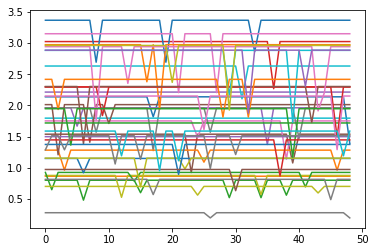

In [23]:
for j in train_data.j.unique():
    foo = train_data[ train_data.j == j]
    plt.plot(foo.t, foo.price)